### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
### Keras and Tensorflow >2.0

In [3]:
### Data Collection
import pandas_datareader as pdr
key=""    # Key obtained by using https://www.tiingo.com/

In [5]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

In [7]:
df.to_csv('AAPL.csv')

In [8]:
import pandas as pd

In [9]:
df=pd.read_csv('AAPL.csv')

In [10]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-11-03 00:00:00+00:00,122.57,123.49,120.70,120.79,45518976,28.313084,28.525599,27.881122,27.901912,182075904,0.00,1.0
1,AAPL,2015-11-04 00:00:00+00:00,122.00,123.82,121.62,123.13,44886050,28.181416,28.601828,28.093638,28.442441,179544200,0.00,1.0
2,AAPL,2015-11-05 00:00:00+00:00,120.92,122.69,120.18,121.85,39552680,28.052059,28.462679,27.880387,28.267808,158210720,0.52,1.0
3,AAPL,2015-11-06 00:00:00+00:00,121.06,121.81,120.62,121.11,33042283,28.084537,28.258529,27.982462,28.096137,132169132,0.00,1.0
4,AAPL,2015-11-09 00:00:00+00:00,120.57,121.81,120.05,120.96,33871405,27.970863,28.258529,27.850229,28.061338,135485620,0.00,1.0


In [11]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2020-10-26 00:00:00+00:00,115.05,116.55,112.8800,114.01,111850657,115.05,116.55,112.8800,114.01,111850657,0.0,1.0
1254,AAPL,2020-10-27 00:00:00+00:00,116.60,117.28,114.5399,115.49,92276772,116.60,117.28,114.5399,115.49,92276772,0.0,1.0
1255,AAPL,2020-10-28 00:00:00+00:00,111.20,115.43,111.1000,115.05,143937823,111.20,115.43,111.1000,115.05,143937823,0.0,1.0
1256,AAPL,2020-10-29 00:00:00+00:00,115.32,116.93,112.2000,112.37,146129173,115.32,116.93,112.2000,112.37,146129173,0.0,1.0
1257,AAPL,2020-10-30 00:00:00+00:00,108.86,111.99,107.7200,111.06,190573476,108.86,111.99,107.7200,111.06,190573476,0.0,1.0


In [12]:
df1=df.reset_index()['close']     # Simply merges the index

In [17]:
df1.shape

(1258,)

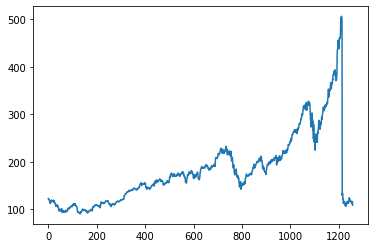

In [15]:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.show()

In [18]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [19]:
import numpy as np

In [20]:
df1

0       122.57
1       122.00
2       120.92
3       121.06
4       120.57
         ...  
1253    115.05
1254    116.60
1255    111.20
1256    115.32
1257    108.86
Name: close, Length: 1258, dtype: float64

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1))

In [29]:
print(df1)           # values transformed between 0 to 1
df1.shape

[[0.07752255]
 [0.07615153]
 [0.07355382]
 ...
 [0.05017438]
 [0.06008419]
 [0.044546  ]]


(1258, 1)

In [30]:
##splitting dataset into train and test split w.r.t time, because sequence has to be preserved
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [31]:
training_size,test_size

(817, 441)

In [32]:
train_data

array([[0.07752255],
       [0.07615153],
       [0.07355382],
       [0.07389056],
       [0.07271197],
       [0.06357186],
       [0.06198437],
       [0.0610463 ],
       [0.05291642],
       [0.05733013],
       [0.05616356],
       [0.06482261],
       [0.06840649],
       [0.06965725],
       [0.06592904],
       [0.06864702],
       [0.06660253],
       [0.06607336],
       [0.06725195],
       [0.06494287],
       [0.06239327],
       [0.05979555],
       [0.06900782],
       [0.06720385],
       [0.06708358],
       [0.06080577],
       [0.06212868],
       [0.05493686],
       [0.05325316],
       [0.04846663],
       [0.05051112],
       [0.04483464],
       [0.03773903],
       [0.0408659 ],
       [0.04062538],
       [0.04394468],
       [0.04254961],
       [0.03963921],
       [0.04425737],
       [0.04084185],
       [0.03588695],
       [0.03610343],
       [0.02975346],
       [0.02491882],
       [0.01469633],
       [0.01592303],
       [0.01969934],
       [0.023

In [33]:
import numpy
# convert an array of values into a dataset matrix              
def create_dataset(dataset, time_step=1):     #here let say time step was 3 then for predicting the price at day 7, day 6,5,4 values would be used
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [35]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [39]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [40]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [41]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [42]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 716 samples, validate on 340 samples
Epoch 1/100
716/716 [==============================] - 16s 23ms/sample - loss: 0.0120 - val_loss: 0.0444
Epoch 2/100
716/716 [==============================] - 5s 7ms/sample - loss: 0.0023 - val_loss: 0.0219
Epoch 3/100
716/716 [==============================] - 6s 8ms/sample - loss: 8.4781e-04 - val_loss: 0.0269
Epoch 4/100
716/716 [==============================] - 5s 7ms/sample - loss: 4.8106e-04 - val_loss: 0.0204
Epoch 5/100
716/716 [==============================] - 5s 7ms/sample - loss: 4.1917e-04 - val_loss: 0.0201
Epoch 6/100
716/716 [==============================] - 4s 6ms/sample - loss: 3.6702e-04 - val_loss: 0.0195
Epoch 7/100
716/716 [==============================] - 4s 5ms/sample - loss: 3.4511e-04 - val_loss: 0.0189
Epoch 8/100
716/716 [==============================] - 4s 6ms/sample - loss: 3.3515e-04 - val_loss: 0.0186
Epoch 9/100
716/716 [==============================] - 4s 6ms/sample - loss: 3.1288e-04 - val_loss: 0.01

In [46]:
import tensorflow as tf

In [47]:
tf.__version__

'2.0.0'

In [48]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [49]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [50]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.010087276303049503

In [51]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.09830846785941862

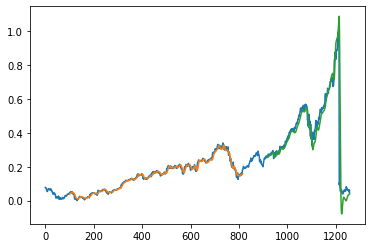

In [52]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [53]:
len(test_data)

441

In [54]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 100)

In [55]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [56]:
temp_input

[0.5906434155141311,
 0.5976187612748045,
 0.607696933253157,
 0.6295610342754059,
 0.6283824413710162,
 0.628719182200842,
 0.6238845460012028,
 0.6458929645219482,
 0.6643174984966926,
 0.6487552615754661,
 0.6602525556223691,
 0.6332892363199039,
 0.6528923631990378,
 0.6601563439567049,
 0.6584966927239928,
 0.6584966927239928,
 0.6819242333132893,
 0.6791340950090199,
 0.7000120264582081,
 0.7039567047504509,
 0.7055682501503309,
 0.7013108839446784,
 0.7165123271196634,
 0.7229344558027659,
 0.7113650030066145,
 0.7094888755261575,
 0.7290198436560433,
 0.7159591100420926,
 0.7185808779314491,
 0.6759831629585087,
 0.673770294648226,
 0.6948887552615755,
 0.6799037883343355,
 0.6971016235718581,
 0.7081659651232712,
 0.8050511124473845,
 0.830811785929044,
 0.8378111846061336,
 0.841635598316296,
 0.8785808779314492,
 0.8517378232110644,
 0.8672760072158752,
 0.8350210463018641,
 0.8699939867708961,
 0.8892363199037885,
 0.8882501503307276,
 0.8853638003607938,
 0.89455201443175,

In [57]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.03962774]
101
1 day input [0.59761876 0.60769693 0.62956103 0.62838244 0.62871918 0.62388455
 0.64589296 0.6643175  0.64875526 0.66025256 0.63328924 0.65289236
 0.66015634 0.65849669 0.65849669 0.68192423 0.6791341  0.70001203
 0.7039567  0.70556825 0.70131088 0.71651233 0.72293446 0.711365
 0.70948888 0.72901984 0.71595911 0.71858088 0.67598316 0.67377029
 0.69488876 0.67990379 0.69710162 0.70816597 0.80505111 0.83081179
 0.83781118 0.8416356  0.87858088 0.85173782 0.86727601 0.83502105
 0.86999399 0.88923632 0.88825015 0.8853638  0.89455201 0.89594708
 0.92064943 0.97929044 0.99360192 0.98366807 1.         0.98544799
 0.9834997  0.09308479 0.10544799 0.09876127 0.07345761 0.07365003
 0.05407096 0.06489477 0.0556825  0.05209862 0.06016837 0.06061335
 0.0524113  0.04810583 0.03968731 0.04748046 0.05164161 0.04036079
 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278 0.06361996
 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233 0.06405292
 0.08192423 0.07398677 0.07420325 0

12 day output [[0.03151572]]
13 day input [0.66015634 0.65849669 0.65849669 0.68192423 0.6791341  0.70001203
 0.7039567  0.70556825 0.70131088 0.71651233 0.72293446 0.711365
 0.70948888 0.72901984 0.71595911 0.71858088 0.67598316 0.67377029
 0.69488876 0.67990379 0.69710162 0.70816597 0.80505111 0.83081179
 0.83781118 0.8416356  0.87858088 0.85173782 0.86727601 0.83502105
 0.86999399 0.88923632 0.88825015 0.8853638  0.89455201 0.89594708
 0.92064943 0.97929044 0.99360192 0.98366807 1.         0.98544799
 0.9834997  0.09308479 0.10544799 0.09876127 0.07345761 0.07365003
 0.05407096 0.06489477 0.0556825  0.05209862 0.06016837 0.06061335
 0.0524113  0.04810583 0.03968731 0.04748046 0.05164161 0.04036079
 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278 0.06361996
 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233 0.06405292
 0.08192423 0.07398677 0.07420325 0.07304871 0.06898376 0.06167168
 0.06535177 0.06381239 0.06111846 0.0594107  0.05943476 0.06316296
 0.05017438 0.06008419

24 day output [[0.03660455]]
25 day input [0.70948888 0.72901984 0.71595911 0.71858088 0.67598316 0.67377029
 0.69488876 0.67990379 0.69710162 0.70816597 0.80505111 0.83081179
 0.83781118 0.8416356  0.87858088 0.85173782 0.86727601 0.83502105
 0.86999399 0.88923632 0.88825015 0.8853638  0.89455201 0.89594708
 0.92064943 0.97929044 0.99360192 0.98366807 1.         0.98544799
 0.9834997  0.09308479 0.10544799 0.09876127 0.07345761 0.07365003
 0.05407096 0.06489477 0.0556825  0.05209862 0.06016837 0.06061335
 0.0524113  0.04810583 0.03968731 0.04748046 0.05164161 0.04036079
 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278 0.06361996
 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233 0.06405292
 0.08192423 0.07398677 0.07420325 0.07304871 0.06898376 0.06167168
 0.06535177 0.06381239 0.06111846 0.0594107  0.05943476 0.06316296
 0.05017438 0.06008419 0.044546   0.03962774 0.03922553 0.03815903
 0.03676219 0.03532086 0.03402161 0.0329607  0.03216917 0.03163984
 0.03134506 0.031249

In [58]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [59]:
import matplotlib.pyplot as plt

In [60]:
len(df1)

1258

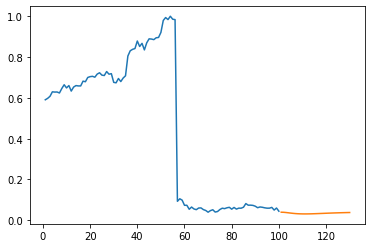

In [67]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

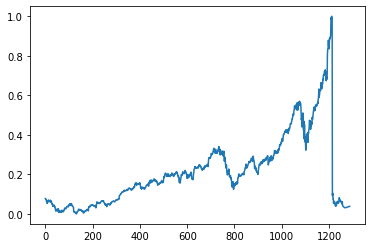

In [69]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3)

In [70]:
df3=scaler.inverse_transform(df3).tolist()

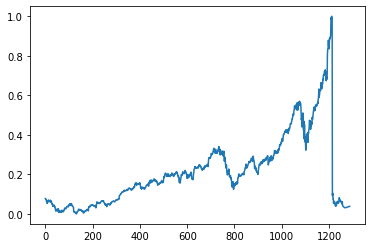

In [71]:
plt.plot(df3)